In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/aysesimsek1498/coviddata/train.tsv


In [23]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [24]:
#a_path = /kaggle/input/coviddata"
df = pd.read_csv('/kaggle/input/d/aysesimsek1498/coviddata/train.tsv', sep='\t', header=0)

In [25]:
df = df.iloc[:, 1]
text = []
for count, item in enumerate(df):
    text.append(df[count])

In [26]:
sample = text[0:4000]
sample[999]

"[Diagnostic algorithm for COVID-19 at the ER] [SEP] OBJECTIVE: Evaluation of a diagnostic algorithm for estimating the risk of COVID-19 in patients who are referred to an emergency department for being suspected of having the disease [SEP] DESIGN: Retrospective study [SEP] METHOD: Patients with fever with no apparent cause and patients with recently developed respiratory symptoms, whether or not in combination with fever, were routinely given a PCR test, blood tests (lymphocyte count and LDH levels) and a chest CT scan [SEP] The CT scan was assessed according to the CO-RADS classification [SEP] Based on the findings, the patients were divided into 3 cohorts (proven COVID-19, strong suspicion of COVID-19, and low suspicion of COVID-19) and the appropriate isolation measures were taken [SEP] RESULTS: In the period from 8 to 31 March 2020, the algorithm was applied to 312 patients [SEP] COVID-19 was proven for 69 (22%) patients [SEP] COVID-19 was strongly suspected for 151 (48%) patients

In [27]:
len(text)

16125

In [28]:
doc = nlp("Suppression of a SARS-CoV-2 outbreak in the Italian municipality of Vo' [SEP] On the 21st of February 2020")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Suppression ... ROOT
of ... prep
a ... det
SARS ... compound
- ... punct
CoV-2 ... compound
outbreak ... pobj
in ... prep
the ... det
Italian ... amod
municipality ... pobj
of ... prep
Vo ... poss
' ... punct
[ ... punct
SEP ... pobj
] ... punct
On ... ROOT
the ... det
21st ... pobj
of ... prep
February ... pobj
2020 ... nummod


In [29]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [30]:
get_entities("ayse is 25 years old")

['ayse', '']

In [31]:
sample = text[0:4000]
entity_pairs = []

for i in tqdm(sample):
    entity_pairs.append(get_entities(i))

100%|██████████| 4000/4000 [03:10<00:00, 21.02it/s]


In [32]:
entity_pairs[500:550]

[['home isolation', 'early family COVID-19'],
 ['binding SARS domain', 'SARS CoV-2 S'],
 ['worldwide meal experience', 'also COVID-19 era'],
 ['that', 'challenging home period'],
 ['rights', 'copyright'],
 ['trained patient physicians', 'practical  onboarding'],
 ['prompt CF Strategies', 'nebulized  medications'],
 ['monitoring', 'diagnostics'],
 ['rights', 'copyright'],
 ['hence SARS it', 'cardiovascular  disease'],
 ['circadian  that', 'COVID-19'],
 ['2019  nCoV', 'reproductive  ACE2'],
 ['definite  implementation', 'effective telemedicine healthcare'],
 ['urgently  review', 'COVID-19'],
 ['existing  evidence', 'diagnosis COVID-19 patients'],
 ['COVID-19 ratio', 'CYP3A4 P450 inflammation'],
 ['pandemic  experiences', 'in person visits'],
 ['sampling sampler most', 'SARS Co PCR analysis'],
 ['financial health care resources', 'pandemic'],
 ['high health we', 'ongoing COVID-19 infection'],
 ['they', 'extra  training'],
 ['various  that', 'recombinant ACE2 protein'],
 ['rights', 'copyri

In [33]:
def get_relation(sent):

  doc = nlp(sent)
  #print(doc)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [34]:
get_relation("ayse completed the task")

'completed'

In [35]:
relations = [get_relation(i) for i in tqdm(sample)]

100%|██████████| 4000/4000 [03:01<00:00, 22.02it/s]


In [36]:
pd.Series(relations).value_counts()[:50]

is                 178
reserved           129
protected by        86
suggest             61
are                 58
needed              58
provide             49
be                  48
discuss             43
suggests            36
have                36
provides            34
SEP                 33
help                30
report              29
was                 28
need                26
aims                25
discussed           25
highlight           22
present             21
CONCLUSIONS         19
propose             19
found               19
describe            18
include             18
reviewed            18
were                18
highlights          18
has                 18
indicate            17
reported            17
hope                17
show                16
believe             15
review              15
demonstrates        15
Conclusion          15
presents            14
considered          14
describes           14
recommended         14
continue            13
had        

In [37]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [38]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [39]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

<Figure size 1200x1200 with 0 Axes>

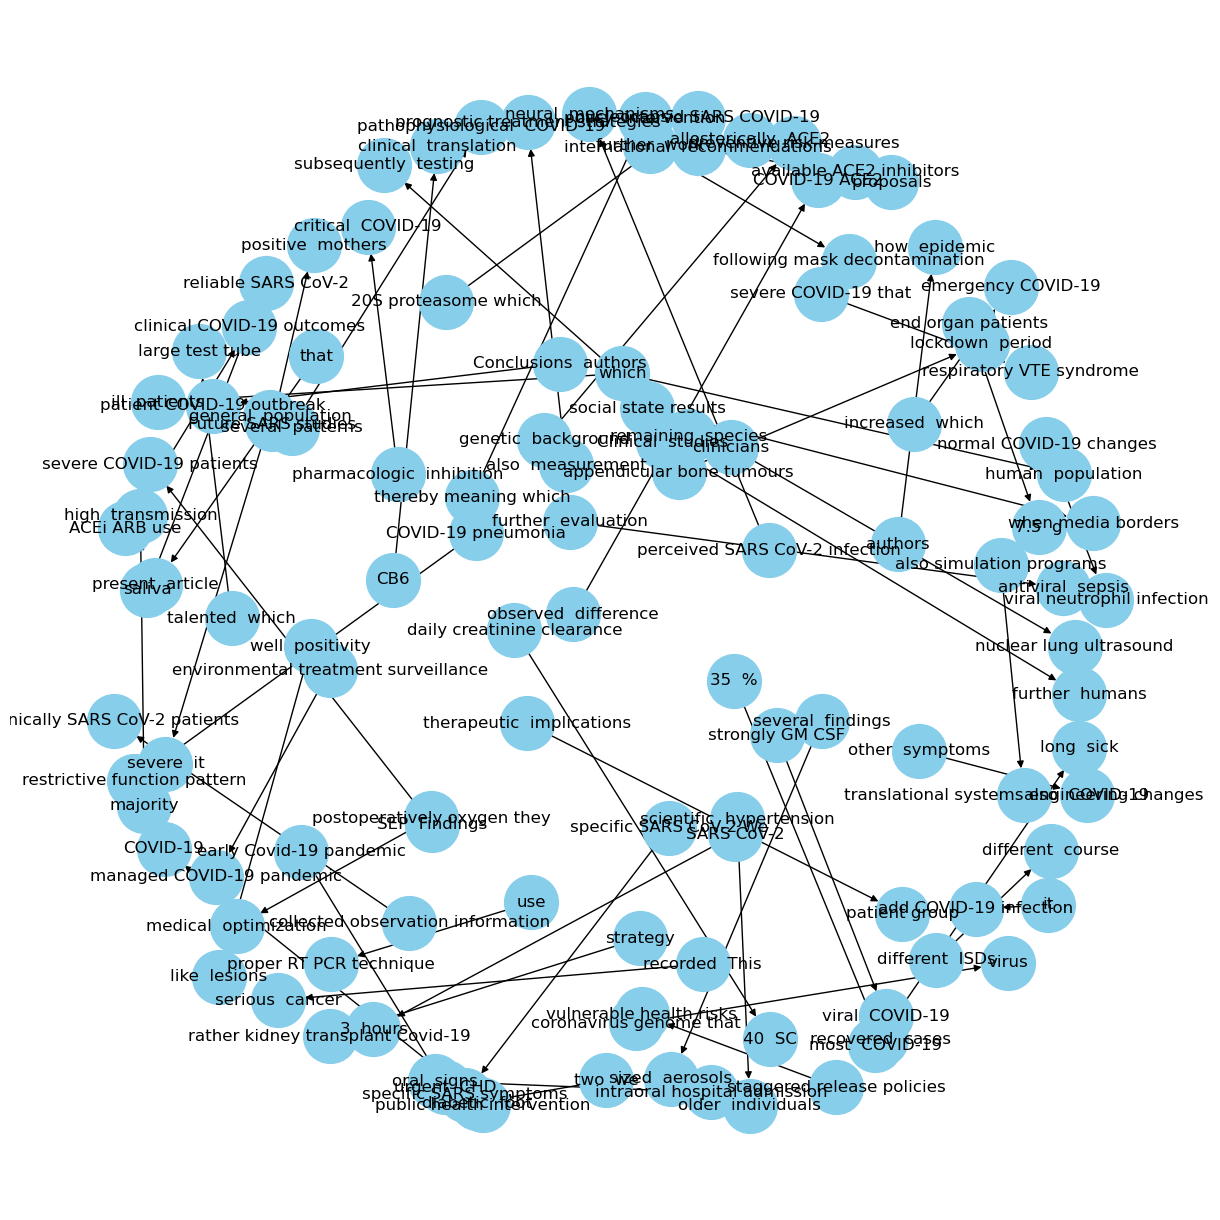

In [40]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="suggest"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

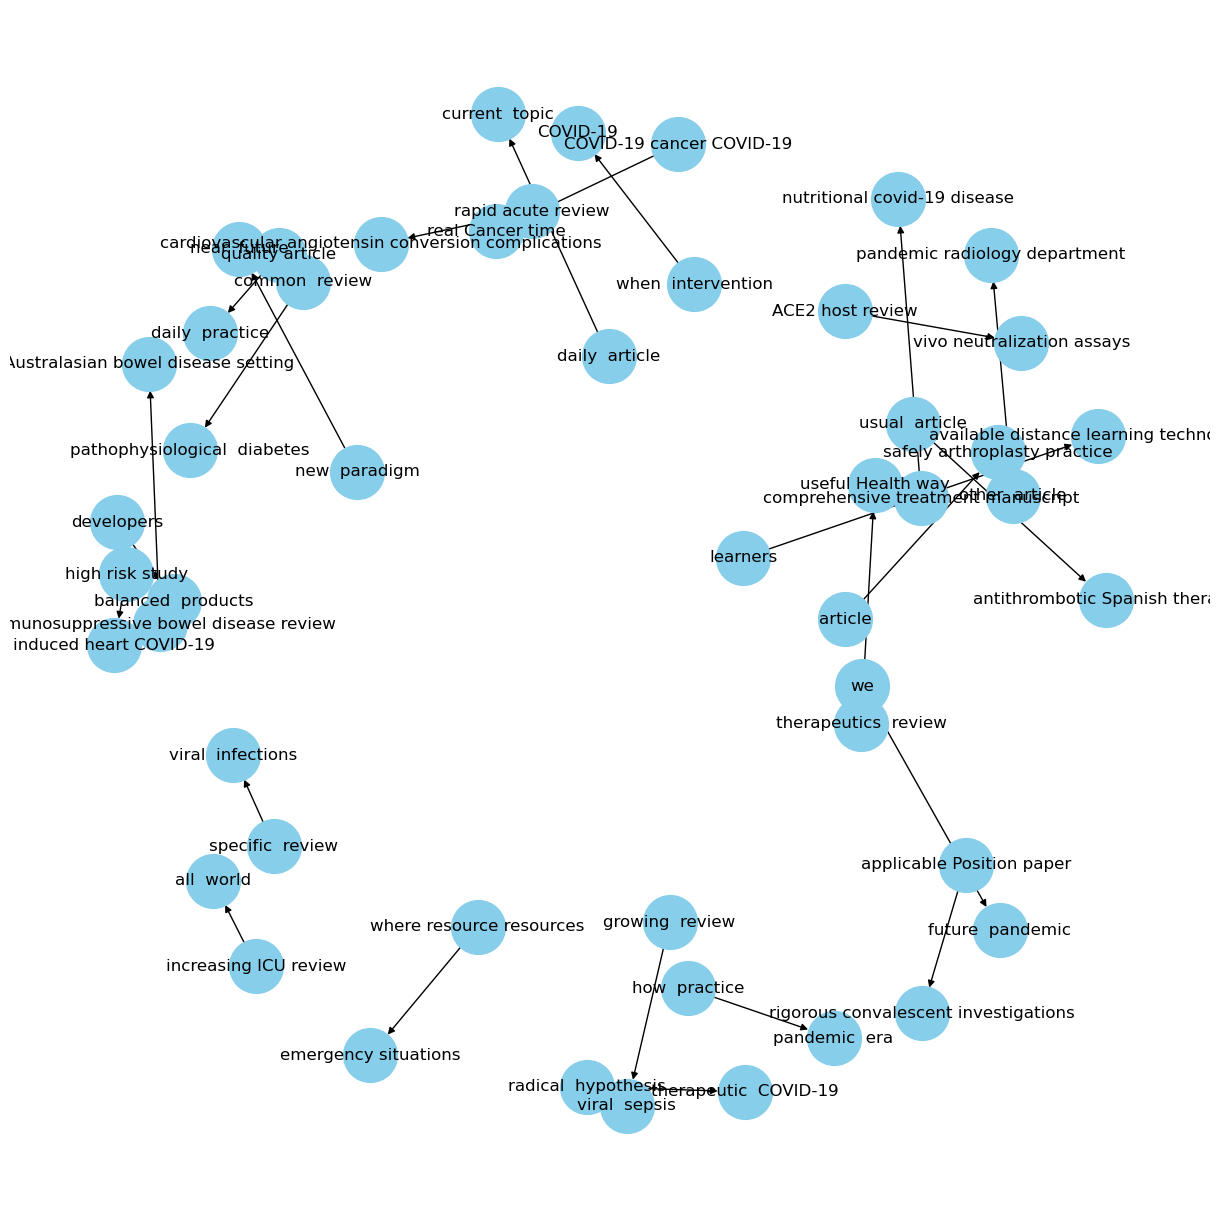

In [41]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="aims"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()